<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">S2R Analytics</h2>

# Table of Contents

**Predictive analytics (ML pipeline)**

* [Part 3](#part3): Exploratory data analysis
<br />
<br />
* [Part 4](#part4): Preprocessing
    * [4.1](#4_1): Outliers
    * [4.2](#4_2): Missing values
    * [4.3](#4_3): Encoding
    * [4.4](#4_4): Scaling
    * [4.5](#4_5): Splitting
<br />
<br />
* [Part 5](#part5): Model training
* [Part 6](#part6): Performance evaluation
* [Part 7](#part7): Feature importance and statistical tests
* [Part 8](#part8): Converting the output
* [Part 9](#part9): Pipeline creation

## Notebook Setup

In [119]:
#Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc

#Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
#from image import image, display

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [145]:
df = pd.read_csv('project_lvl.csv')
df.head()

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_Is_Recent,Project_Director,Perc_of_Subcontractors,Project_Duration_Weeks,Is_Front_Loaded,Delivered_on_Time,Fully_In_Lockdown,Partially_In_Lockdown,Suffered_Data_Loss,Total_Data_Issues,Avg_Rec,Avg_Profit,Staff_ID,Synergy_Team,Employment_Total_Months
0,367704,Australia,Whyalla,Ports & Marine,4.0,False,True,Standard,100.0,False,Mark Gilbert,0.0,4.0,True,NaN,False,False,False,2.0,2.070711,0.991479,7612852.0,SA - Industrial,117.0
1,367705,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Geoff Wallbridge,0.0,NaN,False,NaN,False,False,NaN,2.0,1.926671,0.000000,7612773.0,SA - Buildings,310.0
2,367706,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Loreto Taglienti,0.0,NaN,False,NaN,False,False,NaN,0.0,1.936449,1.290966,7612773.0,SA - Buildings,310.0
3,367707,Australia,WGASA Pty Ltd,Commercial & Retail Buildings,3.0,False,True,Standard,NaN,NaN,Mark Gilbert,0.0,NaN,False,NaN,False,False,NaN,1.0,2.053392,1.631426,7612773.0,SA - Buildings,310.0
4,367708,Australia,WGASA Pty Ltd,Civic & Education Buildings,7.0,False,True,Standard,NaN,NaN,Peter McBean,0.0,NaN,False,NaN,False,False,NaN,3.0,1.082860,0.000000,7612695.0,SA - Buildings,420.0


## Part 3: <a class="anchor" id="part3"></a> Preprocessing

### 3.1 <a class="anchor" id="3_1"></a> Missing values

In [146]:
len(df.columns)

24

In [147]:
# URL: https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
df['non_missing_count'] = df.apply(lambda x: x.count(), axis=1)
df['non_missing_count'].value_counts()

19    4814
23    1904
24    1324
16     608
22     513
20     338
15     117
21      44
17      41
18      31
13      15
12       4
14       2
Name: non_missing_count, dtype: int64

Rows with more than 7 empty columns will be dropped, so the minimum number of non-missing columns per row should be 17.

In [148]:
df = df[(df['non_missing_count']) >= 17]
len(df)

9009

In [149]:
# Number of columns having null values in the dataset
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 115
Perc_of_Stages_with_Fixed_Fee 5778
Manager_Is_Recent 5046
Project_Director 1
Perc_of_Subcontractors 159
Project_Duration_Weeks 5000
Is_Front_Loaded 145
Delivered_on_Time 7038
Suffered_Data_Loss 4975
Avg_Rec 191
Avg_Profit 191
Staff_ID 106
Synergy_Team 106
Employment_Total_Months 106


In [150]:
print('Minimum values each coumn should have is set to e at least half of the dataset, i.e. '+ str(round(len(df)/2))+' rows.')

Minimum values each coumn should have is set to e at least half of the dataset, i.e. 4504 rows.


In [151]:
# Drop ID columns and those with too many missing values
df.drop(columns = ['Staff_ID', 'Perc_of_Stages_with_Fixed_Fee', 'Project_Duration_Weeks', 'Delivered_on_Time', 'Suffered_Data_Loss'], inplace = True)

# Replacing null values with the most frequent strings and booleans
df['Country'].fillna(df['Country'].value_counts().idxmax(), inplace = True)
df['Project_Director'].fillna(df['Project_Director'].value_counts().idxmax(), inplace = True)
df['Is_First_Client_Project'].fillna(df['Is_First_Client_Project'].value_counts().idxmax(), inplace = True)
df['Manager_Is_Recent'].fillna(df['Manager_Is_Recent'].value_counts().idxmax(), inplace = True)
df['Is_Front_Loaded'].fillna(df['Is_Front_Loaded'].value_counts().idxmax(), inplace = True)
df['Synergy_Team'].fillna(df['Synergy_Team'].value_counts().idxmax(), inplace = True)

Whether to perform imputatipon of missed vakues with median or mean, always depends on your data and your task.
If there is a dataset that have great outliers, I'll prefer median. E.x.: 99% of household income is below 100, and 1% is above 500.

First, let's deal with small amoun of nulls. Check: df.boxplot('Perc_of_Stages_with_Fixed_Fee')

In [152]:
# Using median to impute the missing values
missing_size = ['Project_Size_Sort_Order']
for s in missing_size:
    df.loc[df.loc[:,s].isnull(),s]=df.loc[:,s].median()

missing_rec = ['Avg_Rec']
for r in missing_rec:
    df.loc[df.loc[:,r].isnull(),r]=df.loc[:,r].median()
    
missing_profit = ['Avg_Profit']
for p in missing_profit:
    df.loc[df.loc[:,p].isnull(),p]=int(df.loc[:,p].median())

missing_subcontractors = ['Perc_of_Subcontractors']
for s in missing_subcontractors:
    df.loc[df.loc[:,s].isnull(),s]=int(df.loc[:,s].median())

missing_months = ['Employment_Total_Months']
for m in missing_months:
    df.loc[df.loc[:,m].isnull(),m]=int(df.loc[:,m].median())

missing_months = ['Employment_Total_Months']
for m in missing_months:
    df.loc[df.loc[:,m].isnull(),m]=int(df.loc[:,m].median())

In [153]:
# Verify the changes
df.isnull().sum()

Project_ID                     0
Country                        0
Office                         0
Sector                         0
Project_Size_Sort_Order        0
Is_Multi_Discipline_Project    0
Is_First_Client_Project        0
Default_Rate_Group             0
Manager_Is_Recent              0
Project_Director               0
Perc_of_Subcontractors         0
Is_Front_Loaded                0
Fully_In_Lockdown              0
Partially_In_Lockdown          0
Total_Data_Issues              0
Avg_Rec                        0
Avg_Profit                     0
Synergy_Team                   0
Employment_Total_Months        0
non_missing_count              0
dtype: int64

### 3.2 <a class="anchor" id="3_2"></a> Outliers

In [154]:
# URL: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

# seed the random number generator
seed(1)

# calculate interquartile range
q25, q75 = percentile(df['Avg_Rec'], 25), percentile(df['Avg_Rec'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df['Avg_Rec'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df['Avg_Rec'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=1.492, 75th=1.811, IQR=0.320
Identified outliers: 218
Non-outlier observations: 8791


In [155]:
# seed the random number generator
seed(1)

# calculate interquartile range
q25, q75 = percentile(df['Avg_Profit'], 25), percentile(df['Avg_Profit'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df['Avg_Profit'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df['Avg_Profit'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=1.093, 75th=1.996, IQR=0.903
Identified outliers: 562
Non-outlier observations: 8447


Interpretation: https://www.mathbootcamps.com/how-to-read-a-boxplot/

### 3.3 <a class="anchor" id="3_3"></a> Feature engineering

In [156]:
all_bins = pd.DataFrame(df, columns = ['Avg_Rec', 'Avg_Profit'])
all_bins

,Avg_Rec,Avg_Profit
0,2.070711,0.991479
1,1.926671,0.000000
2,1.936449,1.290966
3,2.053392,1.631426
4,1.082860,0.000000
...,...,...
9749,1.646714,1.000000
9750,1.646714,1.000000
9751,1.646714,1.000000
9752,1.646714,1.000000


In [169]:
df['Avg_Rec'].min(), df['Avg_Rec'].median(), df['Avg_Rec'].max()

(0.5876204854256184, 1.6467137666848868, 10816.242165914766)

<AxesSubplot:>

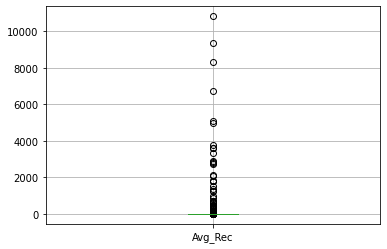

In [157]:
df.boxplot('Avg_Rec')

Now we can create 3 recoverability classes based on the median recoverability as our threshold.

In [172]:
rec_class = {}

for rec in df['Avg_Rec']:
  for project_id in df['Project_ID']:
    if rec <= 1.65:
      rec_class[project_id] = 0 # unprofitable
    elif rec >= 2000:
      rec_class[project_id]  = 2 # extremely profitable
    else:
      rec_class[project_id]  = 1 # average profitable

In [173]:
rec_df = pd.DataFrame([{'Project_ID': project_id, 'Rec_Class': rec_class} for (project_id, rec_class) in rec_class.items()])
rec_df.head()

,Project_ID,Rec_Class
0,367704,0
1,367705,0
2,367706,0
3,367707,0
4,367708,0


In [170]:
df['Avg_Profit'].min(), df['Avg_Profit'].median(), df['Avg_Profit'].max()

(0.0, 1.51034200286709, 16389.220348073926)

<AxesSubplot:>

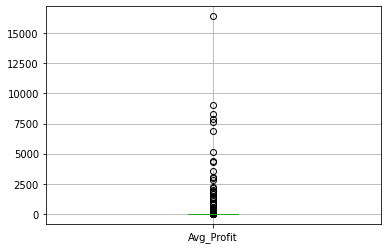

In [171]:
df.boxplot('Avg_Profit')

Now we can create 3 profit measure classes based on the median profit measurement as our threshold.

In [175]:
profit_class = {}

for profit in df['Avg_Profit']:
  for project_id in df['Project_ID']:
    if profit <= 1.51:
      profit_class[project_id] = 0 # unprofitable
    elif profit >= 2500:
      profit_class[project_id]  = 2 # extremely profitable
    else:
      profit_class[project_id]  = 1 # average profitable

In [176]:
profit_df = pd.DataFrame([{'Project_ID': project_id, 'Profit_Class': profit_class} for (project_id, profit_class) in profit_class.items()])
profit_df.head()

,Project_ID,Profit_Class
0,367704,0
1,367705,0
2,367706,0
3,367707,0
4,367708,0


In [179]:
profitability_df = pd.merge(rec_df, profit_df, how='left', left_on='Project_ID', right_on='Project_ID')
profitability_df['Profitability_Class'] = profitability_df['Rec_Class'] + profitability_df['Profit_Class']
profitability_df 

,Project_ID,Rec_Class,Profit_Class,Profitability_Class
0,367704,0,0,0
1,367705,0,0,0
2,367706,0,0,0
3,367707,0,0,0
4,367708,0,0,0
...,...,...,...,...
9004,1523716,0,0,0
9005,1524776,0,0,0
9006,1529864,0,0,0
9007,1538446,0,0,0


In [183]:
profitability_df['Profitability_Class'].value_counts()

0    9009
Name: Profitability_Class, dtype: int64

In [181]:
prep_classes = profitability_df['Profitability_Class'].sum()
#prep_classes.rename(columns={0:'NFT_count'},inplace=True)
#prep_classes.rename(columns={'index': 'category'}, inplace=True)
prep_classes

0

### 3.3 <a class="anchor" id="3_3"></a> Encoding

In [ ]:
# select the float columns
categorical = df.copy()
test = categorical.select_dtypes(include=['object'])

In [ ]:
le = LabelEncoder()
categorical['creator'] = le.fit_transform(categorical['creator'])
categorical.head()

### 3.4 <a class="anchor" id="3_4"></a> Scaling

“To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, we scale the data before feeding it to the model.” (Analytics Vidhya, 2020) In our case, normalisation works better than standardisation, as outliers have been handled, and data does not seem to follow a normal distribution.

In [ ]:
from sklearn import preprocessing
d = preprocessing.normalize(encoded_df)
normal_df = pd.DataFrame(d, columns = encoded_df.columns)
normal_df.head()
len(normal_df)

### 3.5 <a class="anchor" id="3_5"></a> Splitting

In [ ]:
# Split dataset into features and labels
X = df[['creator', 'artwork_name', 'collection',
           'art_series', 'media', 'likes', 'nsfw',
           'tokens','year', 'rights', 'artwork_counts']]  # Removed original price
y = df['price_class']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022) # 80% training and 20% test
print(f"No. of training data: {X_train.shape[0]}")
print(f"No. of training targets: {y_train.shape[0]}")
print(f"No. of testing data: {X_test.shape[0]}")
print(f"No. of testing targets: {y_test.shape[0]}")

## Part 4: <a class="anchor" id="part4"></a> Exploratory data analysis